In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip3 install torch
!pip3 install torchvision
!pip install -U pillow

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x625e4000 @  0x7f093888a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.9MB/s 
    100% |████████████████████████████████| 2.0MB 1.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (5.4.1)


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import time
import json
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torchvision.models import resnet152







In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}


In [0]:
data_dir = 'drive/My Drive/flower_classifier/flower_data' #I hope this line correct and you understood it properly.
train_dir = data_dir + '/train'   #here we are concatinating data_dir with train data within flower_data folder

valid_dir = data_dir + '/valid'#here we are concatinating data_dir with valid data within flower_data folder
dirs = {'train': train_dir, 
        'valid': valid_dir}
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [0]:
cat_to_name = json.load(open('drive/My Drive/cat_to_name.json'))

In [0]:
model = resnet152(pretrained=True)

In [0]:
layers = [
          ('dropout', nn.Dropout(0.2)),
          ('fc1', nn.Linear(2048, 512)),
          ('batchM1',nn.BatchNorm1d(512)),   
          ('relu1', nn.ReLU()),
          ('dropout2', nn.Dropout(0.2)),
          ('fc2', nn.Linear(512, 102)),
          ('output', nn.LogSoftmax(dim=1))
          ]
classifier = nn.Sequential(OrderedDict(layers))
for param in model.parameters():
    param.requires_grad_(True)
model.fc = classifier

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            model = model.to(device)
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
criteria = nn.NLLLoss()

opt = optim.Adadelta(model.parameters(), lr=0.09)

sched = lr_scheduler.StepLR(opt, step_size=8, gamma=0.4)
# Number of epochs
eps=10
model_ft = train_model(model, criteria, opt, sched, eps)

Epoch 0/9
----------
train Loss: 0.0049 Acc: 0.9997
valid Loss: 0.0820 Acc: 0.9817

Epoch 1/9
----------
train Loss: 0.0081 Acc: 0.9989
valid Loss: 0.1075 Acc: 0.9792

Epoch 2/9
----------
train Loss: 0.0071 Acc: 0.9989
valid Loss: 0.0987 Acc: 0.9780

Epoch 3/9
----------
train Loss: 0.0060 Acc: 0.9997
valid Loss: 0.1029 Acc: 0.9780

Epoch 4/9
----------
train Loss: 0.0103 Acc: 0.9983
valid Loss: 0.0841 Acc: 0.9817

Epoch 5/9
----------
train Loss: 0.0089 Acc: 0.9986
valid Loss: 0.1047 Acc: 0.9743

Epoch 6/9
----------
train Loss: 0.0104 Acc: 0.9986
valid Loss: 0.0763 Acc: 0.9829

Epoch 7/9
----------
train Loss: 0.0085 Acc: 0.9985
valid Loss: 0.1157 Acc: 0.9743

Epoch 8/9
----------
train Loss: 0.0055 Acc: 0.9992
valid Loss: 0.0815 Acc: 0.9817

Epoch 9/9
----------
train Loss: 0.0038 Acc: 0.9997
valid Loss: 0.0821 Acc: 0.9841

Training complete in 95m 2s
Best val Acc: 0.984108


In [0]:
def calc_accuracy(model, data):
    model.eval()
    model.to(device)    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[data]):
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            # obtain the outputs from the model
            outputs = model.forward(inputs)
            outputs = outputs.to(device)
            # max provides the (maximum probability, max value)
            _, predicted = outputs.max(dim=1)
            # check the 
            if idx == 0:
                print(predicted) #the predicted class
                print(torch.exp(_)) # the predicted probability
            equals = predicted == labels.data
            if idx == 0:
                print(equals)
            print(equals.float().mean())

In [14]:
calc_accuracy(model, "valid")

tensor([ 50,  60,  59,  80,   4,  17,  81,  97,  60,  77,  96,  67,  73,  54,
         97,  80,  75,   2,  22,  64,  15, 101,  72,  67,  83,  48,  57,  44,
         85,  84,  26,  40], device='cuda:0')
tensor([0.9997, 0.9998, 0.9997, 0.9983, 0.9997, 0.9996, 0.9987, 0.9999, 0.9997,
        0.9994, 0.9998, 0.9995, 0.9993, 0.9994, 0.9989, 0.9981, 0.9991, 0.9982,
        0.9997, 0.9995, 0.9996, 0.9994, 0.9999, 0.9998, 0.9998, 0.9994, 0.9999,
        0.9996, 0.9996, 0.9984, 0.9887, 0.9981], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'resnet152',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'classifier.pth')

In [0]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    if chpt['arch'] == 'resnet152':
        model = models.resnet152(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
        return 
    
    model.class_to_idx = chpt['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                           ('dropout', nn.Dropout(0.2)),
                          ('fc1', nn.Linear(2048, 512)),
                          ('batchM1',nn.BatchNorm1d(512)),   
                          ('relu1', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model.fc = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [17]:
model = load_model('classifier.pth')
calc_accuracy(model, 'valid')

tensor([14, 50, 61, 48,  4, 95, 45, 96, 73, 81, 56, 40,  2,  4, 79, 73, 52, 90,
        38, 77, 38, 93, 89, 41, 97, 77, 36, 43, 81, 53, 18, 43],
       device='cuda:0')
tensor([0.9994, 0.9995, 0.9993, 0.9995, 0.9996, 0.9999, 0.9998, 0.9992, 0.9994,
        0.9999, 0.9986, 0.9993, 0.9980, 0.9992, 0.9992, 0.9994, 0.9997, 0.9993,
        0.9998, 0.9993, 0.6566, 0.9955, 0.9995, 0.9998, 0.9992, 0.9991, 0.9997,
        0.9995, 0.9996, 0.9999, 0.9997, 0.9996], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
tensor(0.9688, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9375, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.9688, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., devic

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

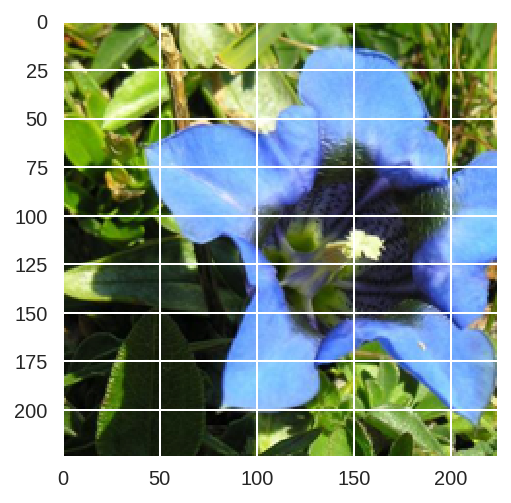

In [22]:
image_path = 'drive/My Drive/flower_classifier/flower_data/valid/28/image_05265.jpg'
img = process_image(image_path)
imshow(img)

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    if torch.cuda.is_available():
      model_input = model_input.cuda()
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().cpu().numpy().tolist()[0] 
    top_labs = top_labs.detach().cpu().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers

In [0]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Set up title
    title_ = flowers[0]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


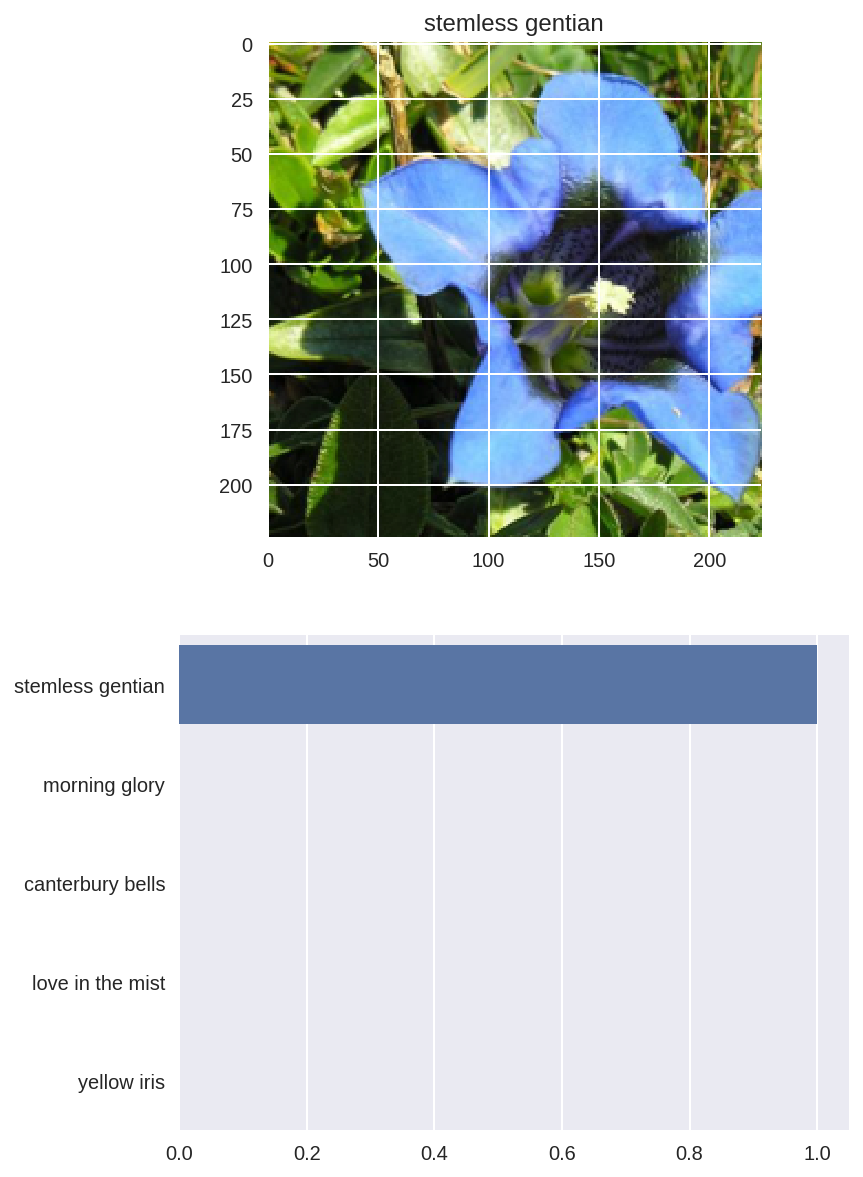

In [31]:
image_path = 'drive/My Drive/flower_classifier/flower_data/valid/28/image_05265.jpg'
plot_solution(image_path, model)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


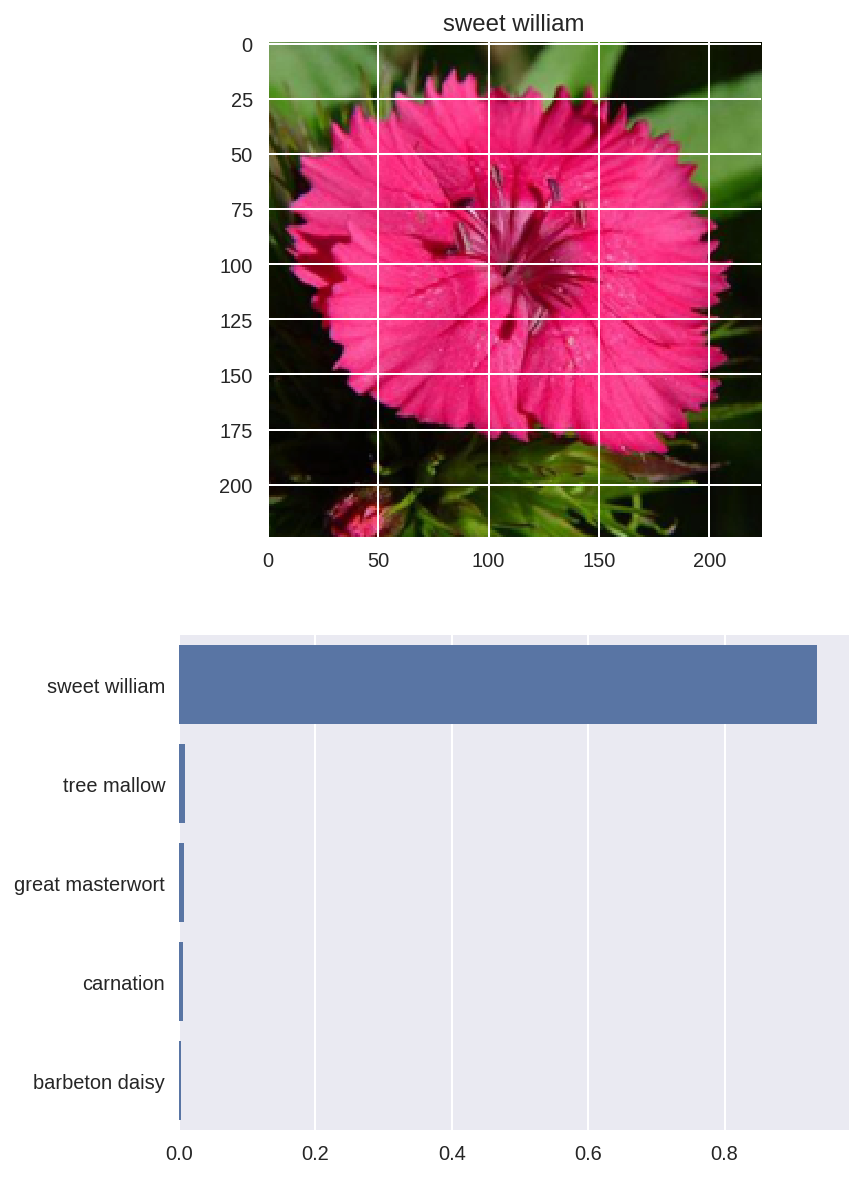

In [32]:
image_path = 'drive/My Drive/flower_classifier/flower_data/valid/30/image_03464.jpg'
plot_solution(image_path, model)